In [ ]:
import zipfile
import os

zip_path = "/content/archive (1).zip"  # uploaded zip file
extract_to = "/content/nifty50_data"   # folder to extract into

# make sure output folder exists
os.makedirs(extract_to, exist_ok=True)

# extract contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction completed successfully!")

# check what got extracted
print("Extracted files:", os.listdir(extract_to)[:20])


✅ Extraction completed successfully!
Extracted files: ['BAJAJ-AUTO.csv', 'ONGC.csv', 'LT.csv', 'ZEEL.csv', 'SHREECEM.csv', 'IOC.csv', 'ADANIPORTS.csv', 'TATASTEEL.csv', 'BHARTIARTL.csv', 'UPL.csv', 'HCLTECH.csv', 'INFY.csv', 'SUNPHARMA.csv', 'KOTAKBANK.csv', 'NTPC.csv', 'BAJFINANCE.csv', 'POWERGRID.csv', 'SBIN.csv', 'CIPLA.csv', 'GRASIM.csv']


In [ ]:
import pandas as pd

df = pd.read_csv('/content/nifty50_data/RELIANCE.csv')
df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']].dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print(df.head())


✅ Data loaded successfully!
Shape: (5306, 5)
             Close    Open    High     Low    Volume
Date                                                
2000-01-03  251.70  237.50  251.70  237.50   4456424
2000-01-04  271.85  258.40  271.85  251.30   9487878
2000-01-05  282.50  256.65  287.90  256.65  26833684
2000-01-06  294.35  289.00  300.70  289.00  15682286
2000-01-07  314.55  295.00  317.90  293.00  19870977


In [ ]:
# Calculate simple moving averages (SMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

# Drop NaN values created during rolling calculations
df.dropna(inplace=True)

print("✅ Feature engineering complete!")
print(df.head())


✅ Feature engineering complete!
             Close   Open    High     Low    Volume    SMA_20   SMA_50  \
Date                                                                     
2000-03-13  203.20  219.9  229.50  200.30  10765401  298.6575  312.236   
2000-03-14  219.20  205.5  219.50  197.15  10106318  292.4000  311.586   
2000-03-15  236.75  224.0  236.75  216.00   5711222  286.8300  310.884   
2000-03-16  234.85  239.5  247.80  230.10  10564295  280.8450  309.931   
2000-03-21  237.90  238.8  242.80  227.60   6838036  275.2675  308.802   

                  RSI       MACD  
Date                              
2000-03-13  10.485086 -29.094597  
2000-03-14  18.827508 -30.112849  
2000-03-15  23.404255 -29.167459  
2000-03-16  24.209078 -28.245942  
2000-03-21  23.599556 -26.958760  


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select only numeric columns for scaling
feature_columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_columns])

# Convert back to DataFrame (same index/columns)
scaled_df = pd.DataFrame(scaled_data, columns=feature_columns, index=df.index)

# Prepare training data — using last 60 days to predict next day
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # 'Close' is the target (index 0)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df.values)

print("✅ Data scaled and sequences created!")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Data scaled and sequences created!
X shape: (5197, 60, 9)
y shape: (5197,)


Train shape: (4157, 60, 9) (4157,)
Test  shape: (1040, 60, 9) (1040,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,901 (800.39 KB)

 Trainable params: 204,901 (800.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0180
Epoch 1: val_loss improved from inf to 0.00170, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 318ms/step - loss: 0.0178 - val_loss: 0.0017
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0017
Epoch 2: val_loss improved from 0.00170 to 0.00126, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0014
Epoch 3: val_loss improved from 0.00126 to 0.00103, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 43s 353ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0011
Epoch 4: val_loss improved from 0.00103 to 0.00097, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 338ms/step - loss: 0.0011 - val_loss: 9.7065e-04
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0011
Epoch 5: val_loss did not improve from 0.00097
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0011
Epoch 6: val_loss did not improve from 0.00097
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0012
Epoch 7: val_loss did not improve from 0.00097
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 9.5046e-04
Epoch 8: val_loss did not improve from 0.00097
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 326ms/step - loss: 9.5156e-04 - val_loss: 0.0022
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0011
Epoch 9: val_loss improved from 0.00097 to 0.00095, saving model to best_lstm_model.h

65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 336ms/step - loss: 0.0011 - val_loss: 9.4971e-04
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 9.2140e-04
Epoch 10: val_loss improved from 0.00095 to 0.00076, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - loss: 9.2079e-04 - val_loss: 7.5901e-04
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 8.9159e-04
Epoch 11: val_loss improved from 0.00076 to 0.00074, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - loss: 8.9149e-04 - val_loss: 7.4361e-04
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 9.5092e-04
Epoch 12: val_loss improved from 0.00074 to 0.00063, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 312ms/step - loss: 9.5065e-04 - val_loss: 6.3176e-04
Epoch 13/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 6.8780e-04
Epoch 13: val_loss did not improve from 0.00063
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - loss: 6.8908e-04 - val_loss: 7.0513e-04
Epoch 14/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 8.9496e-04
Epoch 14: val_loss improved from 0.00063 to 0.00061, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - loss: 8.9518e-04 - val_loss: 6.1029e-04
Epoch 15/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 7.2870e-04
Epoch 15: val_loss did not improve from 0.00061
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - loss: 7.3070e-04 - val_loss: 9.4445e-04
Epoch 16/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 7.9827e-04
Epoch 16: val_loss did not improve from 0.00061
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - loss: 7.9713e-04 - val_loss: 0.0013
Epoch 17/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 7.5118e-04
Epoch 17: val_loss improved from 0.00061 to 0.00057, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - loss: 7.5188e-04 - val_loss: 5.7480e-04
Epoch 18/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 8.4312e-04
Epoch 18: val_loss improved from 0.00057 to 0.00052, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - loss: 8.4201e-04 - val_loss: 5.2402e-04
Epoch 19/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 6.7891e-04
Epoch 19: val_loss did not improve from 0.00052
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 351ms/step - loss: 6.7913e-04 - val_loss: 6.4593e-04
Epoch 20/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 6.6369e-04
Epoch 20: val_loss did not improve from 0.00052
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 313ms/step - loss: 6.6387e-04 - val_loss: 9.7717e-04
Epoch 21/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 6.4395e-04
Epoch 21: val_loss improved from 0.00052 to 0.00049, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - loss: 6.4473e-04 - val_loss: 4.9470e-04
Epoch 22/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 7.4387e-04
Epoch 22: val_loss did not improve from 0.00049
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - loss: 7.4336e-04 - val_loss: 0.0010
Epoch 23/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 6.5149e-04
Epoch 23: val_loss did not improve from 0.00049
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - loss: 6.5152e-04 - val_loss: 6.7971e-04
Epoch 24/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 5.8901e-04
Epoch 24: val_loss did not improve from 0.00049
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - loss: 5.8980e-04 - val_loss: 9.6324e-04
Epoch 25/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 6.9591e-04
Epoch 25: val_loss improved from 0.00049 to 0.00048, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - loss: 6.9538e-04 - val_loss: 4.8398e-04
Epoch 26/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 5.7301e-04
Epoch 26: val_loss did not improve from 0.00048
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - loss: 5.7371e-04 - val_loss: 5.7504e-04
Epoch 27/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 5.6250e-04
Epoch 27: val_loss improved from 0.00048 to 0.00047, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step - loss: 5.6253e-04 - val_loss: 4.7341e-04
Epoch 28/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 6.5962e-04
Epoch 28: val_loss did not improve from 0.00047
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 493ms/step - loss: 6.5826e-04 - val_loss: 6.6534e-04
Epoch 29/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 6.4979e-04
Epoch 29: val_loss did not improve from 0.00047
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 338ms/step - loss: 6.4963e-04 - val_loss: 0.0012
Epoch 30/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 6.6049e-04
Epoch 30: val_loss improved from 0.00047 to 0.00046, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - loss: 6.5918e-04 - val_loss: 4.5615e-04
Epoch 31/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 4.7772e-04
Epoch 31: val_loss did not improve from 0.00046
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - loss: 4.7862e-04 - val_loss: 4.7006e-04
Epoch 32/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 5.2840e-04
Epoch 32: val_loss did not improve from 0.00046
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - loss: 5.2875e-04 - val_loss: 5.7908e-04
Epoch 33/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 5.2970e-04
Epoch 33: val_loss improved from 0.00046 to 0.00045, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - loss: 5.2942e-04 - val_loss: 4.5192e-04
Epoch 34/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 5.1392e-04
Epoch 34: val_loss improved from 0.00045 to 0.00036, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 328ms/step - loss: 5.1376e-04 - val_loss: 3.6194e-04
Epoch 35/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 4.8800e-04
Epoch 35: val_loss did not improve from 0.00036
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - loss: 4.8829e-04 - val_loss: 6.5263e-04
Epoch 36/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 5.3651e-04
Epoch 36: val_loss improved from 0.00036 to 0.00033, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - loss: 5.3600e-04 - val_loss: 3.2935e-04
Epoch 37/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 5.2250e-04
Epoch 37: val_loss did not improve from 0.00033
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - loss: 5.2238e-04 - val_loss: 3.3840e-04
Epoch 38/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 4.5585e-04
Epoch 38: val_loss did not improve from 0.00033
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - loss: 4.5640e-04 - val_loss: 3.9967e-04
Epoch 39/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 6.5182e-04
Epoch 39: val_loss did not improve from 0.00033
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - loss: 6.5062e-04 - val_loss: 6.3391e-04
Epoch 40/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 5.2223e-04
Epoch 40: val_loss did not improve from 0.00033
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - loss: 5.2210e-04 - val_loss: 3.3612e-04
Epoch 41/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 5.7423e-04
Epoch 41: val_loss did not i

65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - loss: 6.0579e-04 - val_loss: 3.1678e-04
Epoch 44/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 4.0450e-04
Epoch 44: val_loss improved from 0.00032 to 0.00031, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - loss: 4.0561e-04 - val_loss: 3.1462e-04
Epoch 45/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 5.0476e-04
Epoch 45: val_loss did not improve from 0.00031
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - loss: 5.0448e-04 - val_loss: 4.0810e-04
Epoch 46/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 3.8545e-04
Epoch 46: val_loss did not improve from 0.00031
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - loss: 3.8649e-04 - val_loss: 0.0013
Epoch 47/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 5.6503e-04
Epoch 47: val_loss improved from 0.00031 to 0.00029, saving model to best_lstm_model.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - loss: 5.6321e-04 - val_loss: 2.8817e-04
Epoch 48/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 4.3334e-04
Epoch 48: val_loss did not improve from 0.00029
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - loss: 4.3366e-04 - val_loss: 3.0030e-04
Epoch 49/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 4.6667e-04
Epoch 49: val_loss did not improve from 0.00029
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - loss: 4.6583e-04 - val_loss: 3.0896e-04
Epoch 50/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 4.4352e-04
Epoch 50: val_loss did not improve from 0.00029
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 316ms/step - loss: 4.4336e-04 - val_loss: 3.8554e-04


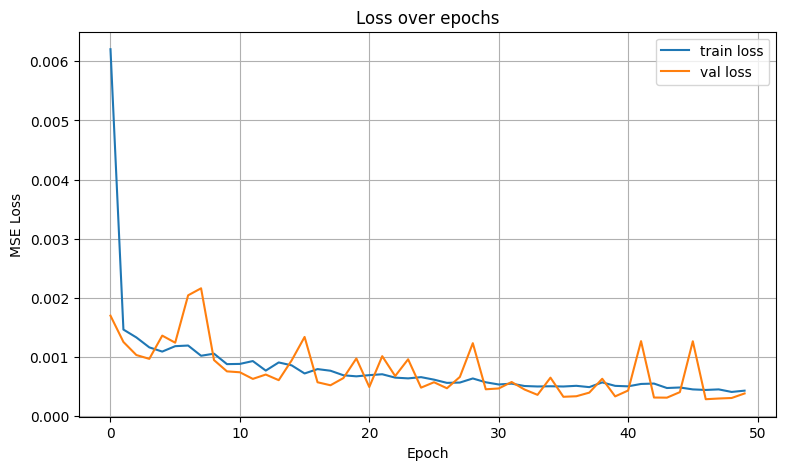


✅ Training finished. Saved: best_lstm_model.h5, LSTM_Model.h5, scaler.pkl


In [ ]:
# STEP 6 — Build, train LSTM, save model + scaler, and plot loss
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

# Ensure X, y and scaler exist from previous step
try:
    X.shape, y.shape
except NameError:
    raise RuntimeError("X and y are not defined. Run the previous scaling / sequence cell first.")

# Train/test split (keep temporal order: use last portion for test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test  shape:", X_test.shape, y_test.shape)

# Build model (same structure you used)
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Checkpoint to save best model by val_loss
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Fit model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,        # change if you want fewer epochs
    batch_size=64,
    callbacks=[checkpoint],
    verbose=1
)

# Save final model (HDF5 legacy) and scaler object
model.save("LSTM_Model.h5")            # legacy HDF5 file (your notebook used this)
joblib.dump(scaler, "scaler.pkl")

# Plot loss
plt.figure(figsize=(9,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ Training finished. Saved: best_lstm_model.h5, LSTM_Model.h5, scaler.pkl")


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
✅ Predictions generated!
Predicted prices: [1035.10846674 1045.06278836 1053.71946704 1055.35435865 1057.09240338]
Actual prices: [1051.3 1067.5 1075.5 1075.4 1088.2]


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


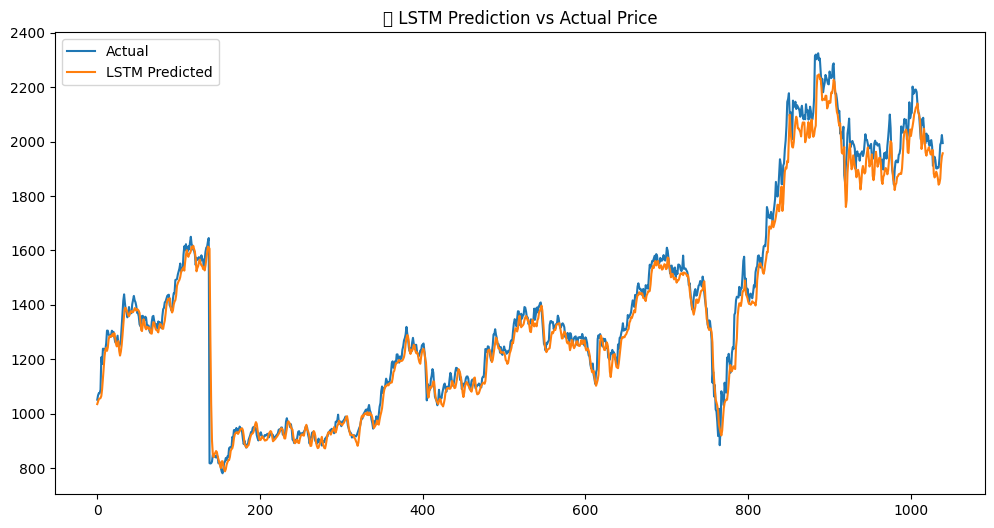

In [ ]:
# Generate predictions for test data
lstm_pred = model.predict(X_test)

# To inverse scale correctly:
dummy_pred = np.zeros((len(lstm_pred), scaled_data.shape[1]))
dummy_pred[:, 0] = lstm_pred[:, 0]
predicted_prices = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_actual = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_actual[:, 0] = y_test
actual_prices = scaler.inverse_transform(dummy_actual)[:, 0]

print("✅ Predictions generated!")
print("Predicted prices:", predicted_prices[:5])
print("Actual prices:", actual_prices[:5])

# Optional — visualize
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='LSTM Predicted')
plt.title('📈 LSTM Prediction vs Actual Price')
plt.legend()
plt.show()



BACKTEST SUMMARY
----------------
Samples: 1040
Strategy final cumulative return: 1.027639 (x)
Buy-and-hold cumulative return:     1.897175 (x)
Annualized Sharpe (strategy):       0.124
Max Drawdown (strategy):            -15.527%
Prediction RMSE:                    59.2522
Prediction MAE:                     37.9292
Avg daily strategy return:          3.801395e-05


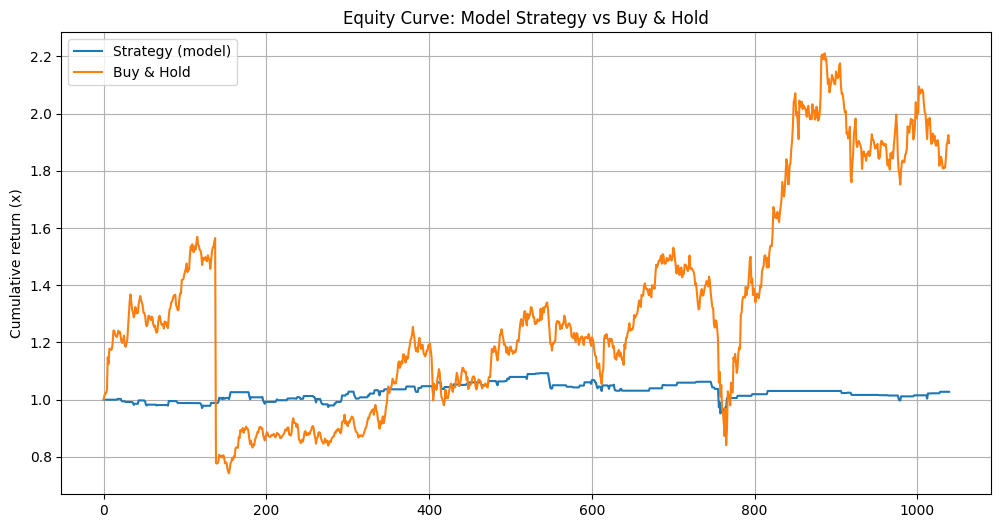

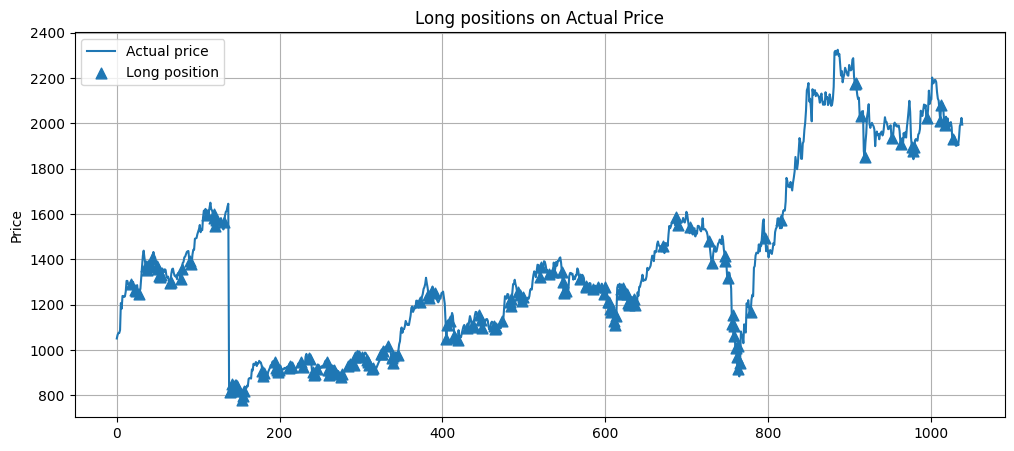

Saved backtest_results.csv (first 5 rows):
      actual    predicted  signal  position  actual_return  strategy_return_pre_cost  pos_change  trade_cost  strategy_return  cum_strategy  cum_buy_hold
date                                                                                                                                                     
0     1051.3  1035.108467       0       0.0       0.000000                       0.0         0.0         0.0              0.0           1.0      1.000000
1     1067.5  1045.062788       0       0.0       0.015409                       0.0         0.0         0.0              0.0           1.0      1.015409
2     1075.5  1053.719467       0       0.0       0.007494                       0.0         0.0         0.0              0.0           1.0      1.023019
3     1075.4  1055.354359       0       0.0      -0.000093                      -0.0         0.0         0.0             -0.0           1.0      1.022924
4     1088.2  1057.092403       0

In [ ]:
# BACKTEST (robust): assumes actual_prices and predicted_prices exist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---- Config (tweak these) ----
threshold = 0.0025        # signal threshold (0.25%): predict > actual*(1+threshold) => long
transaction_cost = 0.0005 # per-trade cost as fraction (0.05% per trade). Set 0 to ignore.
position_fraction = 0.5   # fraction of portfolio used per trade (0..1). 1 = full portfolio each trade.
annual_trading_days = 252
# -------------------------------

# Safety checks
try:
    actual_prices
    predicted_prices
except NameError:
    raise RuntimeError("actual_prices / predicted_prices not found. Run the prediction cell first.")

# Build test dates aligned to X_test / y_test
try:
    # scaled_df: full DataFrame used to build sequences, seq_len variable used previously
    total_samples = len(scaled_df) - seq_len
    train_size = int(total_samples * 0.8)
    test_start_idx = seq_len + train_size
    test_dates = scaled_df.index[test_start_idx:test_start_idx + len(actual_prices)]
    test_dates = pd.to_datetime(test_dates)
except Exception:
    # fallback: create integer index if scaled_df not available
    test_dates = pd.RangeIndex(start=0, stop=len(actual_prices), step=1)

# Make DataFrame
bt = pd.DataFrame({
    'date': test_dates,
    'actual': actual_prices,
    'predicted': predicted_prices
}).set_index('date')

# Signals: if predicted > actual*(1+threshold) -> long next day
bt['signal'] = 0
bt.loc[bt['predicted'] > bt['actual'] * (1 + threshold), 'signal'] = 1

# Position applied next day (we assume signal at close leads to position next day)
bt['position'] = bt['signal'].shift(1).fillna(0)

# Returns
bt['actual_return'] = bt['actual'].pct_change().fillna(0)
# Strategy return before costs
bt['strategy_return_pre_cost'] = bt['position'] * bt['actual_return']

# Apply transaction costs when position changes (entering or exiting)
# Determine trades (1 when entering a long from 0)
bt['pos_change'] = bt['position'].diff().fillna(0).abs()
# If pos_change == 1 -> a trade happened (enter or exit) — charge transaction_cost on that day's trade
# We'll approximate cost by subtracting transaction_cost * position_fraction on trade days from strategy return
bt['trade_cost'] = bt['pos_change'] * transaction_cost * position_fraction
bt['strategy_return'] = bt['strategy_return_pre_cost'] - bt['trade_cost']

# If using fraction of portfolio: scale returns by position_fraction
bt['strategy_return'] = bt['strategy_return'] * position_fraction

# Cumulative returns
bt['cum_strategy'] = (1 + bt['strategy_return']).cumprod()
bt['cum_buy_hold'] = (1 + bt['actual_return']).cumprod()

# Metrics
sharpe = (bt['strategy_return'].mean() / (bt['strategy_return'].std() + 1e-12)) * (annual_trading_days**0.5)
running_max = bt['cum_strategy'].cummax()
drawdown = (bt['cum_strategy'] - running_max) / running_max
max_drawdown = drawdown.min()

rmse = sqrt(mean_squared_error(bt['actual'], bt['predicted']))
mae = mean_absolute_error(bt['actual'], bt['predicted'])

# Summary print
print("BACKTEST SUMMARY")
print("----------------")
print(f"Samples: {len(bt)}")
print(f"Strategy final cumulative return: {bt['cum_strategy'].iloc[-1]:.6f} (x)")
print(f"Buy-and-hold cumulative return:     {bt['cum_buy_hold'].iloc[-1]:.6f} (x)")
print(f"Annualized Sharpe (strategy):       {sharpe:.3f}")
print(f"Max Drawdown (strategy):            {max_drawdown:.3%}")
print(f"Prediction RMSE:                    {rmse:.4f}")
print(f"Prediction MAE:                     {mae:.4f}")
print(f"Avg daily strategy return:          {bt['strategy_return'].mean():.6e}")

# Plots
plt.figure(figsize=(12,6))
plt.plot(bt.index, bt['cum_strategy'], label='Strategy (model)')
plt.plot(bt.index, bt['cum_buy_hold'], label='Buy & Hold')
plt.title('Equity Curve: Model Strategy vs Buy & Hold')
plt.ylabel('Cumulative return (x)')
plt.legend()
plt.grid(True)
plt.show()

# Price + buy markers
plt.figure(figsize=(12,5))
plt.plot(bt.index, bt['actual'], label='Actual price')
buy_points = bt[bt['position'] == 1].index
plt.scatter(buy_points, bt.loc[buy_points, 'actual'], marker='^', s=60, label='Long position', zorder=5)
plt.title('Long positions on Actual Price')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Save CSV
bt.to_csv("backtest_results.csv")
print("Saved backtest_results.csv (first 5 rows):")
print(bt.head().to_string())

# If you'd like, show cumulative returns numeric breakdown
print("\nCumulative returns (start, mid, end):")
print(bt['cum_strategy'].iloc[[0, max(0,len(bt)//2 - 1), -1]].to_list())


Using existing 'bt' DataFrame from prior backtest.

Transaction Cost Sensitivity Summary:


,final_cum,sharpe,max_drawdown,rmse
trade_cost,,,,
0.0000,1.053655,0.203021,-0.150393,59.252215
0.0001,1.048400,0.187292,-0.151370,59.252215
0.0005,1.027639,0.124369,-0.155271,59.252215
0.0010,1.002262,0.045717,-0.160121,59.252215
0.0020,0.953364,-0.111487,-0.169741,59.252215


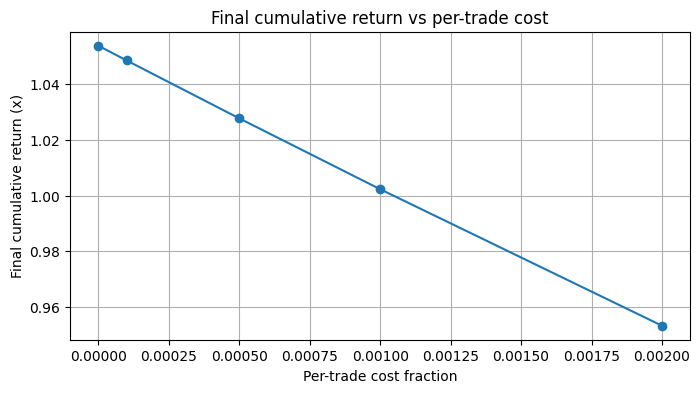

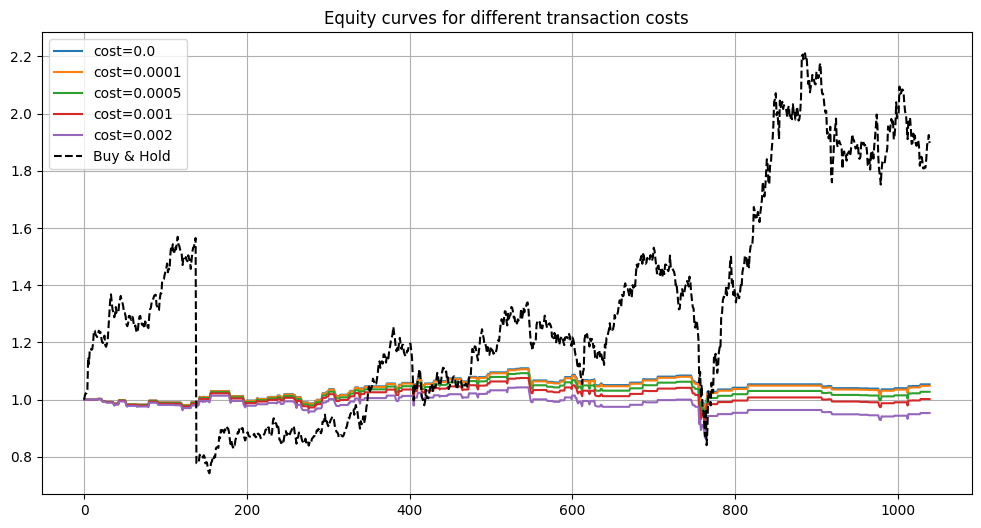

Saved transaction_cost_sensitivity_summary.csv


In [ ]:
# Transaction cost sensitivity sweep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# ---- Config ----
cost_grid = [0.0, 0.0001, 0.0005, 0.001, 0.002]   # per-trade cost fractions to test
position_fraction = 0.5
threshold = 0.0025
annual_trading_days = 252
# ------------------

# Helper: rebuild bt if not available
def build_bt_from_preds(actual_prices, predicted_prices, scaled_df=None, seq_len=60):
    # get test_dates if possible
    try:
        total_samples = len(scaled_df) - seq_len
        train_size = int(total_samples * 0.8)
        test_start_idx = seq_len + train_size
        test_dates = scaled_df.index[test_start_idx:test_start_idx + len(actual_prices)]
        test_dates = pd.to_datetime(test_dates)
    except Exception:
        test_dates = pd.RangeIndex(start=0, stop=len(actual_prices), step=1)
    bt_local = pd.DataFrame({
        'date': test_dates,
        'actual': actual_prices,
        'predicted': predicted_prices
    }).set_index('date')
    return bt_local

# Ensure variables exist
try:
    bt
    print("Using existing 'bt' DataFrame from prior backtest.")
except NameError:
    try:
        actual_prices, predicted_prices
        print("Rebuilding bt from actual_prices & predicted_prices...")
        bt = build_bt_from_preds(actual_prices, predicted_prices, scaled_df if 'scaled_df' in globals() else None, seq_len if 'seq_len' in globals() else 60)
    except Exception as e:
        raise RuntimeError("Cannot find existing backtest data. Run the prediction + backtest cells first to create `actual_prices` and `predicted_prices` or `bt`.") from e

# Function to run backtest given a per-trade cost
def run_backtest_with_cost(bt_df, trade_cost, position_fraction=0.5, threshold=0.0025):
    df = bt_df.copy()
    df['signal'] = 0
    df.loc[df['predicted'] > df['actual'] * (1 + threshold), 'signal'] = 1
    df['position'] = df['signal'].shift(1).fillna(0)
    df['actual_return'] = df['actual'].pct_change().fillna(0)
    df['strategy_return_pre_cost'] = df['position'] * df['actual_return']
    df['pos_change'] = df['position'].diff().fillna(0).abs()
    df['trade_cost'] = df['pos_change'] * trade_cost * position_fraction
    df['strategy_return'] = df['strategy_return_pre_cost'] - df['trade_cost']
    df['strategy_return'] = df['strategy_return'] * position_fraction
    df['cum_strategy'] = (1 + df['strategy_return']).cumprod()
    df['cum_buy_hold'] = (1 + df['actual_return']).cumprod()
    # metrics
    sharpe = (df['strategy_return'].mean() / (df['strategy_return'].std() + 1e-12)) * (annual_trading_days**0.5)
    running_max = df['cum_strategy'].cummax()
    drawdown = (df['cum_strategy'] - running_max) / running_max
    max_drawdown = drawdown.min()
    final_cum = df['cum_strategy'].iloc[-1]
    # prediction RMSE
    rmse = sqrt(mean_squared_error(df['actual'], df['predicted']))
    return {
        'trade_cost': trade_cost,
        'final_cum': final_cum,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'rmse': rmse,
        'df': df
    }

# Run sweep
results = []
dfs = {}
for c in cost_grid:
    res = run_backtest_with_cost(bt, c, position_fraction=position_fraction, threshold=threshold)
    results.append(res)
    dfs[c] = res['df']

# Summary table
summary = pd.DataFrame([{
    'trade_cost': r['trade_cost'],
    'final_cum': r['final_cum'],
    'sharpe': r['sharpe'],
    'max_drawdown': r['max_drawdown'],
    'rmse': r['rmse']
} for r in results]).set_index('trade_cost')
print("\nTransaction Cost Sensitivity Summary:")
display(summary)

# Plot final cumulative returns vs cost
plt.figure(figsize=(8,4))
plt.plot(summary.index, summary['final_cum'], marker='o')
plt.title('Final cumulative return vs per-trade cost')
plt.xlabel('Per-trade cost fraction')
plt.ylabel('Final cumulative return (x)')
plt.grid(True)
plt.show()

# Plot equity curves for each cost (overlay)
plt.figure(figsize=(12,6))
for c, d in dfs.items():
    plt.plot(d.index, d['cum_strategy'], label=f'cost={c}')
plt.plot(dfs[cost_grid[0]].index, dfs[cost_grid[0]]['cum_buy_hold'], '--', label='Buy & Hold', color='k')
plt.title('Equity curves for different transaction costs')
plt.legend()
plt.grid(True)
plt.show()

# Save results
summary.to_csv("transaction_cost_sensitivity_summary.csv")
print("Saved transaction_cost_sensitivity_summary.csv")


ATR-based Position Sizing Backtest Summary
-----------------------------------------
Samples: 1040
Strategy final cumulative return: 1.051668 (x)
Buy-and-hold cumulative return:     1.897175 (x)
Annualized Sharpe (strategy):       0.218
Max Drawdown (strategy):            -8.730%
Prediction RMSE:                    59.2522
Prediction MAE:                     37.9292


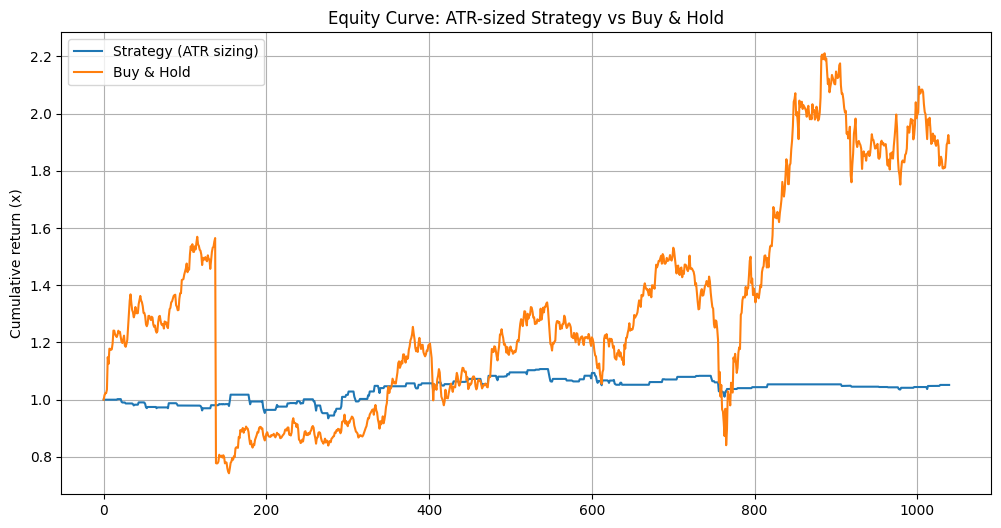

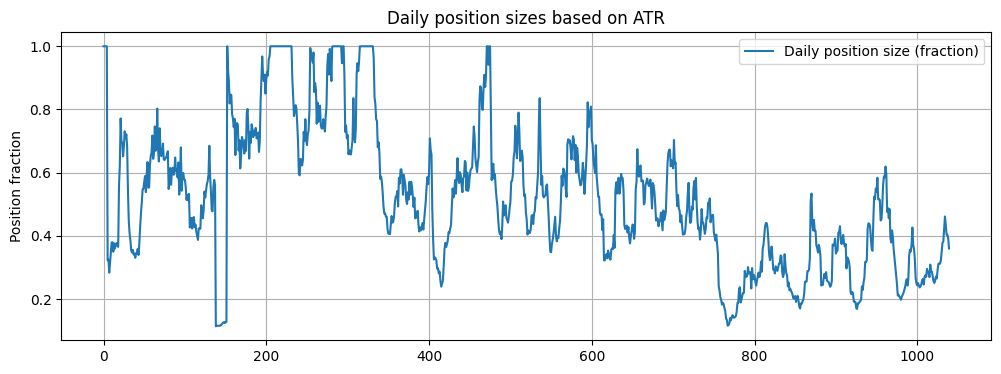

Saved backtest_atr_sizing.csv (first 5 rows):
      actual    predicted           ATR  pos_size  signal  position  position_size  actual_return  strategy_return_pre_cost  pos_change  trade_cost  strategy_return  cum_strategy  cum_buy_hold
date                                                                                                                                                                                            
0     1051.3  1035.108467  1.000000e-08       1.0       0       0.0            0.0       0.000000                       0.0         0.0         0.0              0.0           1.0      1.000000
1     1067.5  1045.062788  8.100000e+00       1.0       0       0.0            0.0       0.015409                       0.0         0.0         0.0              0.0           1.0      1.015409
2     1075.5  1053.719467  8.066667e+00       1.0       0       0.0            0.0       0.007494                       0.0         0.0         0.0              0.0           1.0    

In [ ]:
# ATR-BASED POSITION SIZING BACKTEST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

# ---------- Config ----------
risk_target = 0.01          # target fractional risk per trade (1% of portfolio)
min_pos = 0.05              # minimum fraction of capital to allocate on a trade
max_pos = 1.0               # maximum fraction of capital to allocate on a trade
atr_window = 14             # ATR lookback window used for sizing
threshold = 0.0025          # prediction threshold for taking long
transaction_cost = 0.0005   # per-trade cost fraction
annual_trading_days = 252
# ----------------------------

# Safety: need actual_prices & predicted_prices
try:
    actual_prices
    predicted_prices
except NameError:
    raise RuntimeError("actual_prices and predicted_prices are not in memory. Run the prediction step first.")

# Build bt DataFrame (try to reuse existing bt if present)
try:
    bt  # if exists, use it but rebuild to be safe
    use_existing_bt = True
except NameError:
    use_existing_bt = False

# Attempt to get index/dates
try:
    total_samples = len(scaled_df) - seq_len
    train_size = int(total_samples * 0.8)
    test_start_idx = seq_len + train_size
    test_dates = scaled_df.index[test_start_idx:test_start_idx + len(actual_prices)]
    test_dates = pd.to_datetime(test_dates)
except Exception:
    test_dates = pd.RangeIndex(start=0, stop=len(actual_prices), step=1)

bt_atr = pd.DataFrame({
    'date': test_dates,
    'actual': actual_prices,
    'predicted': predicted_prices
}).set_index('date')

# compute ATR on the actual price series using true highs/lows if available; fallback to using returns-based proxy
# If you have original df with High & Low aligned to test_dates, compute ATR properly.
# Try to align high/low from scaled_df (if available)
if 'High' in globals().get('df', pd.DataFrame()).columns and 'Low' in globals().get('df', pd.DataFrame()).columns:
    # try to pick matching slice from df
    try:
        # locate the rows for test_dates inside df
        # If scaled_df.index correspond to df.index, use scaled_df index mapping
        high_series = df.loc[bt_atr.index, 'High']
        low_series = df.loc[bt_atr.index, 'Low']
        close_series = df.loc[bt_atr.index, 'Close']
    except Exception:
        high_series = bt_atr['actual']  # fallback
        low_series = bt_atr['actual']
        close_series = bt_atr['actual']
else:
    # fallback: use actual price for all high/low/close (ATR will be zero -> use proxy)
    high_series = bt_atr['actual']
    low_series = bt_atr['actual']
    close_series = bt_atr['actual']

# True range
tr1 = high_series - low_series
tr2 = (high_series - close_series.shift(1)).abs()
tr3 = (low_series - close_series.shift(1)).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
atr = tr.rolling(window=atr_window, min_periods=1).mean().fillna(method='bfill')  # simple ATR

# In case atr is zero anywhere (flat series), replace tiny values
atr = atr.replace(0, 1e-8)

# Normalize ATR to a scale that makes sizing stable: use median ATR as baseline
atr_median = atr.median()
atr_normalized = atr / atr_median  # ~1 when ATR ~ median

# Position sizing per day: proportional to (risk_target / atr_normalized), then clipped to [min_pos, max_pos]
# Intuition: when ATR is large (atr_normalized > 1), position shrinks; when ATR small, position grows.
pos_raw = (risk_target / atr_normalized)
# Normalize so that pos_raw median equals some reasonable baseline; clip
pos = pos_raw / pos_raw.median()  # now median ~1
# scale to desired max_pos range, then clip
pos = pos * (max_pos * 0.5)  # scale down a bit so max realistic
pos = pos.clip(lower=min_pos, upper=max_pos)

bt_atr['ATR'] = atr.values
bt_atr['pos_size'] = pos.values

# Generate signals (same as before) & use pos_size on days when position==1
bt_atr['signal'] = 0
bt_atr.loc[bt_atr['predicted'] > bt_atr['actual'] * (1 + threshold), 'signal'] = 1
bt_atr['position'] = bt_atr['signal'].shift(1).fillna(0)  # take position next day
bt_atr['position_size'] = bt_atr['position'] * bt_atr['pos_size']

# Compute returns
bt_atr['actual_return'] = bt_atr['actual'].pct_change().fillna(0)
bt_atr['strategy_return_pre_cost'] = bt_atr['position_size'] * bt_atr['actual_return']

# transaction costs: apply when position changes (enter/exit)
bt_atr['pos_change'] = bt_atr['position'].diff().fillna(0).abs()
bt_atr['trade_cost'] = bt_atr['pos_change'] * transaction_cost * bt_atr['position_size']
bt_atr['strategy_return'] = bt_atr['strategy_return_pre_cost'] - bt_atr['trade_cost']

# Cumulative returns
bt_atr['cum_strategy'] = (1 + bt_atr['strategy_return']).cumprod()
bt_atr['cum_buy_hold'] = (1 + bt_atr['actual_return']).cumprod()

# Metrics
sharpe = (bt_atr['strategy_return'].mean() / (bt_atr['strategy_return'].std() + 1e-12)) * (annual_trading_days**0.5)
running_max = bt_atr['cum_strategy'].cummax()
drawdown = (bt_atr['cum_strategy'] - running_max) / running_max
max_drawdown = drawdown.min()

rmse = sqrt(mean_squared_error(bt_atr['actual'], bt_atr['predicted']))
mae = (abs(bt_atr['actual'] - bt_atr['predicted']).mean())

# Print summary
print("ATR-based Position Sizing Backtest Summary")
print("-----------------------------------------")
print(f"Samples: {len(bt_atr)}")
print(f"Strategy final cumulative return: {bt_atr['cum_strategy'].iloc[-1]:.6f} (x)")
print(f"Buy-and-hold cumulative return:     {bt_atr['cum_buy_hold'].iloc[-1]:.6f} (x)")
print(f"Annualized Sharpe (strategy):       {sharpe:.3f}")
print(f"Max Drawdown (strategy):            {max_drawdown:.3%}")
print(f"Prediction RMSE:                    {rmse:.4f}")
print(f"Prediction MAE:                     {mae:.4f}")

# Plots
plt.figure(figsize=(12,6))
plt.plot(bt_atr.index, bt_atr['cum_strategy'], label='Strategy (ATR sizing)')
plt.plot(bt_atr.index, bt_atr['cum_buy_hold'], label='Buy & Hold')
plt.title('Equity Curve: ATR-sized Strategy vs Buy & Hold')
plt.ylabel('Cumulative return (x)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(bt_atr.index, bt_atr['pos_size'], label='Daily position size (fraction)')
plt.title('Daily position sizes based on ATR')
plt.ylabel('Position fraction')
plt.legend()
plt.grid(True)
plt.show()

# Save results
bt_atr.to_csv("backtest_atr_sizing.csv")
print("Saved backtest_atr_sizing.csv (first 5 rows):")
print(bt_atr.head().to_string())


📊 Model Evaluation Metrics:
RMSE: 59.2522
MAE:  37.9292
R²:   0.9767


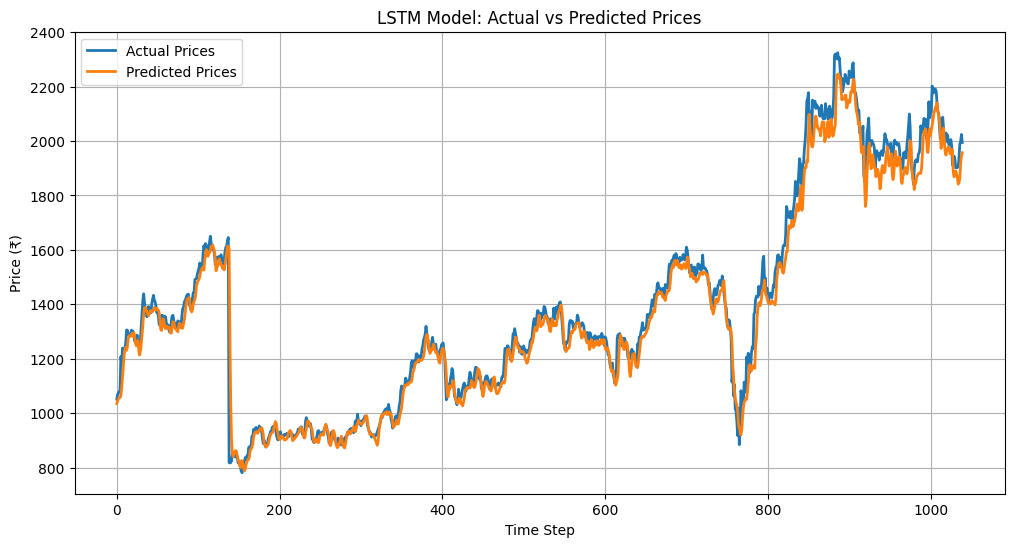

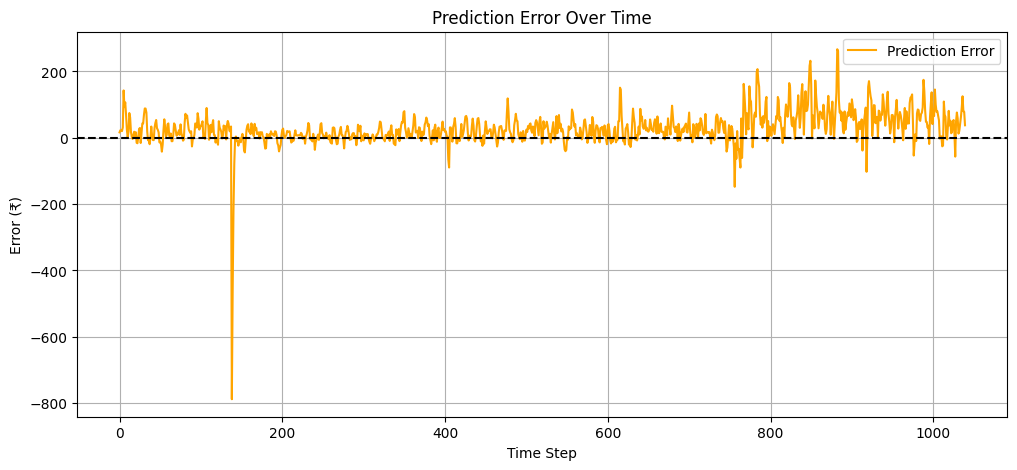

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate standard evaluation metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"📊 Model Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# Compare actual vs predicted visually
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Prices', linewidth=2)
plt.plot(predicted_prices, label='Predicted Prices', linewidth=2)
plt.title('LSTM Model: Actual vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.show()

# Add a unique visualization — error over time
errors = actual_prices - predicted_prices
plt.figure(figsize=(12,5))
plt.plot(errors, label='Prediction Error', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Prediction Error Over Time')
plt.xlabel('Time Step')
plt.ylabel('Error (₹)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os, glob
files = glob.glob('*') + glob.glob('**/*', recursive=True)
expected = [
  "LSTM_Model.h5", "best_lstm_model.h5", "scaler.pkl",
  "reliance_tail_100.csv",
  "backtest_results.csv",
  "backtest_atr_sizing.csv",
  "transaction_cost_sensitivity_summary.csv"
]
for f in expected:
    print(f, "FOUND" if any(x.endswith(f) for x in files) else "MISSING")


LSTM_Model.h5 FOUND
best_lstm_model.h5 FOUND
scaler.pkl FOUND
reliance_tail_100.csv MISSING
backtest_results.csv FOUND
backtest_atr_sizing.csv FOUND
transaction_cost_sensitivity_summary.csv FOUND
